# Ephaptic Coupling model analysis

Some experiments to (better) understand the model

In [1]:
import matplotlib.pyplot as plt
from scipy import signal, special
from collections import Counter
import pandas as pd

In [2]:
from matplotlib import rcParams
rcParams.update({
    'font.family': 'serif',
})

In [3]:
# %load mean_field_model.py
import attr
import numpy as np

# SI base units
s = 1
kg = 1
m = 1
A = 1

# derived units
S = s**3*A**2/(kg*m**2)
V = kg*m**2*s**-3*A**-1
F = s**4 * A**2 * m**-2 * kg ** -1
Hz = 1/s

# with prefixes
nS = 1e-9 * S
uS = 1e-6 * S
mV = 1e-3 * V
uV = 1e-6 * V
pF = 1e-12 * F
ms = 1e-3 * s
nA = 1e-9 * A
pA = 1e-12 * A


def kuhn_transfer_function(threshold, tau_eff, mu_u, sigma_sq_u):
    return 1. / (2 * tau_eff) * (special.erfc((threshold - mu_u) /
                                 (np.sqrt(2) * np.sqrt(sigma_sq_u))))


def derivative_kuhn_transfer_function(threshold, tau_eff,  mu_u, sigma_sq_u):
    return 1. / (2 * tau_eff * (np.sqrt(2 * sigma_sq_u)) * (2/ np.sqrt(np.pi)) *
                 np.exp(-(threshold - mu_u) ** 2 / (2 * sigma_sq_u)))


@attr.s
class EIMeanField:
    E_e = attr.ib(0 * mV)
    E_i = attr.ib(-75 * mV)
    E_l = attr.ib(-70 * mV)
    g_l = attr.ib(1./60 * uS)
    C = attr.ib(250 * pF)
    v_reset = attr.ib(-60 * mV)
    threshold = attr.ib(-50 * mV)
    threshold_inh = attr.ib(-53 * mV)
    tau_ref = attr.ib(2 * ms)
    T_e = attr.ib(0.2 * ms)  # width of excitatory PSC (ms)
    T_i = attr.ib(2 * ms)    # width of inhibitory PSC (ms)
    tau_e = attr.ib(1 * ms)  # timescale of excitatory population (ms)
    tau_i = attr.ib(0.5 * ms)    # timescale of inhibitory population (ms)
    B_e = attr.ib(7.1 * nS)    # peak excitatory conductance (nS)
    B_i = attr.ib(3.7 * nS)    # peak inhibitory conductance (nS)

    f_ext = attr.ib(5000 * Hz) # etracellular_firing_rate

    n_e = attr.ib(350.) # number of excitatory neurons
    n_i = attr.ib(350. / 4.) # number of inhibitory neurons

    noise_std_e = attr.ib(2000 * Hz / np.sqrt(s))
    noise_std_i = attr.ib(0 * Hz / np.sqrt(s))

    tau_adapt = attr.ib(800 * ms) # adaptation time constant
    beta_adapt = attr.ib(0.00005*mV / Hz) # strength of adaptation (per firing rate of E population)

    def calc_membrane_stats(self, fr_e, fr_i):

        mu_ge = fr_e * self.B_e * self.T_e * np.exp(1)
        mu_gi = fr_i * self.B_i * self.T_i * np.exp(1)

        gtot = self.g_l + mu_ge + mu_gi

        mu_u = (self.E_l * self.g_l + self.E_e * mu_ge + self.E_i * mu_gi) / gtot

        tau_eff = self.C / gtot

        epsp_int = (self.E_e - mu_u) * self.B_e * self.T_e * np.exp(1) * tau_eff / self.C
        ipsp_int = (self.E_i - mu_u) * (self.B_i * self.T_i * np.exp(1) * tau_eff / self.C)
        epsp_sq =  epsp_int ** 2 * (2 * tau_eff + self.T_e) /(4 * (tau_eff + self.T_e)**2)
        ipsp_sq =  ipsp_int ** 2 * (2 * tau_eff + self.T_i) /(4 * (tau_eff + self.T_i)**2)
        sigma_sq_u = fr_e * epsp_sq + fr_i * ipsp_sq

        return gtot, mu_u, tau_eff, sigma_sq_u


    def calc_output_rate_inh_exc(self, fr_e, fr_i, delta_v_e=0, delta_v_i=0):
        gtot_exc, mu_u_exc, tau_eff_exc, sigma_sq_u_exc = self.calc_membrane_stats(fr_e=fr_e, fr_i=fr_i)
        gtot_inh, mu_u_inh, tau_eff_inh, sigma_sq_u_inh = self.calc_membrane_stats(fr_e=fr_e, fr_i=fr_i)

        rexc = kuhn_transfer_function(self.threshold + delta_v_e, tau_eff_exc, mu_u_exc, sigma_sq_u_exc)
        rinh = kuhn_transfer_function(self.threshold_inh + delta_v_i, tau_eff_inh, mu_u_inh, sigma_sq_u_inh)

        return rexc * self.n_e, rinh * self.n_i

    def ode_step(self, dt, rexc, rinh, theta_adapt, dv_e=0, dv_i=0):
        fexc, finh = self.calc_output_rate_inh_exc(rexc + self.f_ext,
                              rinh, theta_adapt + dv_e, dv_i)
        theta_adapt = theta_adapt + ((-theta_adapt +
                 self.beta_adapt * rexc) *
                 dt / self.tau_adapt)
        rinh = rinh + (-rinh + finh) * dt / self.tau_i
        rexc = rexc + (-rexc + fexc) * dt / self.tau_e


        return rexc, rinh, theta_adapt

    def sde_step(self, dt, rexc, rinh, theta_adapt, dv_e=0, dv_i=0):
        rexc, rinh, theta_adapt = self.ode_step(dt, rexc, rinh, theta_adapt, dv_e, dv_i)
        rexc += np.random.randn() * self.noise_std_e * np.sqrt(dt)
        rinh += np.random.randn() * self.noise_std_i * np.sqrt(dt)
        rexc = np.maximum(rexc, 0)
        rinh = np.maximum(rinh, 0)

        return rexc, rinh, theta_adapt

### 1.Running the model

In [4]:
# parameters and init
tau_adapt = 800 * ms # adaptation time constant
beta_adapt = 0.00005*mV / Hz # strength of adaptation (per firing rate of E population)
dt = 1. * ms # integration time step
tau_e = 10*ms # time constant of excitatory population
tau_i = 5* ms # time constant of inhibitory population
threshold_inh0 = -51 * mV # inhibitory threshold
noise_e = 2000 * Hz / s 
tmax = 20 * s
f_ext = 1000 * Hz

model = EIMeanField(tau_adapt=tau_adapt,
                    beta_adapt=beta_adapt,
                    tau_e=tau_e,
                    tau_i=tau_i,
                    threshold_inh=threshold_inh0,
                    noise_std_e=noise_e,
                    noise_std_i=0,
                    f_ext=f_ext
                    )

In [5]:
# running simulation
np.random.seed(100)
rexc = 100 * Hz
rinh = 100 * Hz
theta_adapt = 0 * mV
gamma = 0 * uV # in theory V/m
dt = 1*ms
t = 0
solution = []
while t < tmax:
    rexc, rinh, theta_adapt = model.sde_step(dt, rexc, rinh, theta_adapt, gamma)
    t += dt
    solution.append((rexc, rinh, theta_adapt))
solution = np.array(solution)
time = np.arange(solution.shape[0]) * dt

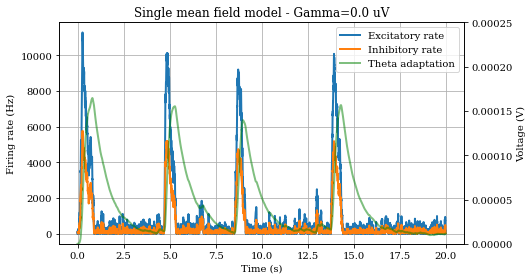

In [6]:
# plot
def plot_single(time, solution, title, savefig=None):
    fig, ax = plt.subplots(figsize=(7.5,4))
    l1 = ax.plot(time, solution[:,0], label="Excitatory rate", lw=2.0)[0]
    l2 = ax.plot(time, solution[:,1], label="Inhibitory rate", lw=2.0)[0]

    ax2 = ax.twinx()
    ax2.set_ylim([0.0,0.00025])
    l3 = ax2.plot(time, solution[:,2], label="Theta adaptation", lw=2.0,alpha=0.5, c='green')[0]

    lines = [l1,l2,l3]

    ax.legend(lines, [l.get_label() for l in lines])
    ax.set(title=title,
           xlabel="Time (s)",
           ylabel="Firing rate (Hz)")
    ax2.set(ylabel="Voltage (V)")
    ax.grid()
    
    fig.tight_layout()

    fig.show()

    if savefig:
        fig.savefig(f'./img/{savefig}')
    
plot_single(time, solution, title=f'Single mean field model - Gamma={gamma/uV} uV',savefig='0gamma_single.pdf')

### 2.Single population with exogenous current (simple gamma addition)

In [7]:
# parameters and init
model_params = {
'tau_adapt': 800 * ms, # adaptation time constant
'beta_adapt': 0.00005*mV / Hz, # strength of adaptation (per firing rate of E population)
'tau_e': 10*ms, # time constant of excitatory population
'tau_i': 5* ms, # time constant of inhibitory population
'threshold_inh': -51 * mV, # inhibitory threshold
'noise_std_e': 2000 * Hz / s, 
'noise_std_i': 0,
'f_ext': 1000 * Hz,
}

model = EIMeanField(**model_params)

In [8]:
# running simulation
simulation_params = {
    'seed': 100,
    'rexc': 100*Hz,
    'rinh': 100*Hz,
    'theta_adapt': 0*mV,
    'gamma': 0*uV,
    'dt': 1*ms,
    'tmax': 20*s,
} 

def run_single(model, seed=100, rexc_i=100*Hz, rinh_i=100*Hz, theta_i=0*mV, gamma=0*uV, dt=1*ms, tmax=20*s):
    np.random.seed(100)
    
    rexc = rexc_i
    rinh = rinh_i
    theta = theta_i
    
    t = 0
    solution = []
    while t < tmax:
        rexc, rinh, theta = model.sde_step(dt, rexc, rinh, theta, gamma)
        t += dt
        solution.append((rexc, rinh, theta))
    solution = np.array(solution)
    time = np.arange(solution.shape[0]) * dt
    
    return time, solution



**Positive gamma** There are less peaks

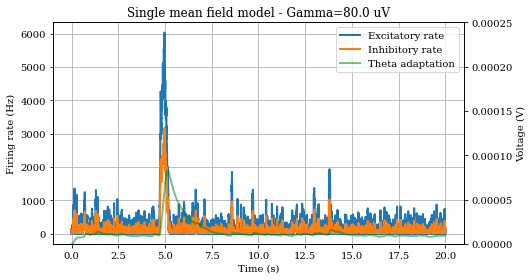

In [9]:
time, solution = run_single(model, gamma=80*uV)
plot_single(time, solution, title=f'Single mean field model - Gamma={80.0} uV',savefig='80gamma_single.pdf')

**Negative gamma** There are more peaks

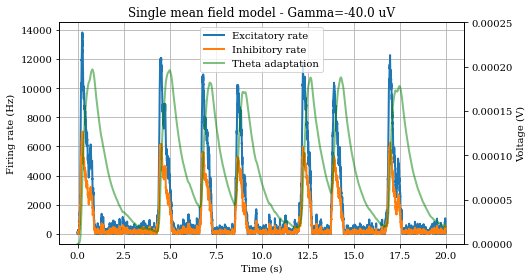

In [170]:
time, solution = run_single(model, gamma=-40*uV)
plot_single(time, solution, title=f'Single mean field model - Gamma={-40.0} uV',savefig='-40gamma_single.pdf')

**Positive (big) gamma** There are no peaks

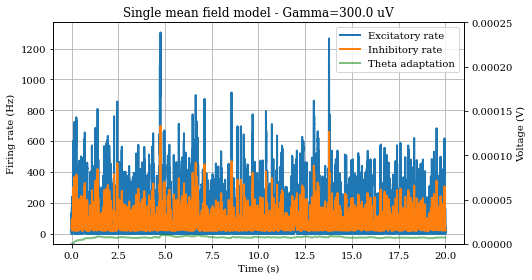

In [171]:
time, solution = run_single(model, gamma=300*uV)
plot_single(time, solution, title=f'Single mean field model - Gamma={300.0} uV',savefig='300gamma_single.pdf')

**Negative (big) gamma** One big peak and then saturation at 10k hz for excitatory and 5k hz for inhibitory

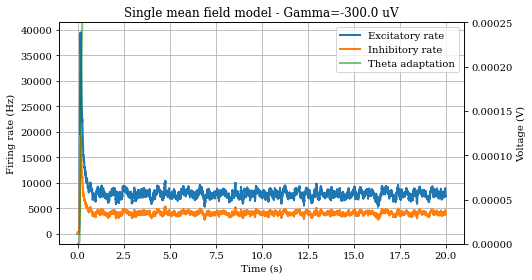

In [172]:
time, solution = run_single(model, gamma=-300*uV)
plot_single(time, solution, title=f'Single mean field model - Gamma={-300.0} uV',savefig='-300gamma_single.pdf')

### 3.Gamma-Frequency plot

Frequency detector with hysteresis

In [9]:
# Frequency detector with hysteresis
time, solution = run_single(model, gamma=-85*uV, tmax=40*s)

There are 17 peaks


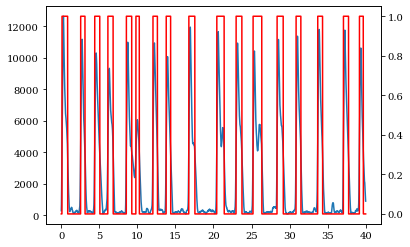

In [10]:
from collections import Counter

# 1.moving average
sol = solution[:,0]
sol = np.convolve(sol, np.ones(250), 'same')/250
# 2.threshold the signal
thr = sol>4000
# 3.count ascending jumps
values = thr.astype('int')
# 3.1 Computes the crossing 1: ascendent -1: descendent
difference = values[1:]-values[:-1]
# 3.2 Count the number of 1 (ascendent crossings)
peaks = Counter(difference)[1]

plt.plot(time, sol)
plt.twinx()
plt.plot(time, thr,c='r')

print(f"There are {peaks} peaks")

In [10]:
def count_peaks(signal, thr_val=4000, ones=250):
    # 1.moving average
    signal = signal
    signal = np.convolve(signal, np.ones(ones))/ones
    # 2.threshold the signal
    thr = signal>thr_val
    # 3.count ascending jumps
    values = thr.astype('int')
    # 3.1 Computes the crossing 1: ascendent -1: descendent
    difference = values[1:]-values[:-1]
    # 3.2 Count the number of 1 (ascendent crossings)
    peaks = Counter(difference)[1]
    return peaks

Run experiments

In [11]:
def write(fn, string, t="a"):
    f = open(fn, t)
    f.write(string)
    f.close()

In [16]:
# params
fn = "gamma_results.txt"
time = 500*s # (!)
gammas = np.linspace(-300,150,100)*uV
#seeds = np.linspace(1000,100000,10,dtype=int)
seeds = [100]

write(fn,"gamma,seed,frequency\n",t="w")

for gamma in gammas:
    current = 0
    for seed in seeds:
        _ , solution = run_single(model, seed=seed, gamma=gamma, tmax=time)
        frequency = count_peaks(solution[:,0])/time
        current += frequency
        
        write(fn,f"{gamma}, {seed}, {frequency} \n")
        
        print(".", end="")
        #print(f"Gamma = {gamma/uV:2f} uV - Seed = {seed} - Frequency = {frequency} Hz")
    
    print(f"\nGamma = {gamma/uV:.3f} uV - Frequency (avg) = {current/10:.3f} Hz")



.
Gamma = -300.000 uV - Frequency (avg) = 0.000 Hz
.
Gamma = -295.455 uV - Frequency (avg) = 0.000 Hz
.
Gamma = -290.909 uV - Frequency (avg) = 0.000 Hz
.
Gamma = -286.364 uV - Frequency (avg) = 0.000 Hz
.
Gamma = -281.818 uV - Frequency (avg) = 0.000 Hz
.
Gamma = -277.273 uV - Frequency (avg) = 0.000 Hz
.
Gamma = -272.727 uV - Frequency (avg) = 0.000 Hz
.
Gamma = -268.182 uV - Frequency (avg) = 0.000 Hz
.
Gamma = -263.636 uV - Frequency (avg) = 0.000 Hz
.
Gamma = -259.091 uV - Frequency (avg) = 0.000 Hz
.
Gamma = -254.545 uV - Frequency (avg) = 0.000 Hz
.
Gamma = -250.000 uV - Frequency (avg) = 0.000 Hz
.
Gamma = -245.455 uV - Frequency (avg) = 0.000 Hz
.
Gamma = -240.909 uV - Frequency (avg) = 0.000 Hz
.
Gamma = -236.364 uV - Frequency (avg) = 0.000 Hz
.
Gamma = -231.818 uV - Frequency (avg) = 0.001 Hz
.
Gamma = -227.273 uV - Frequency (avg) = 0.001 Hz
.
Gamma = -222.727 uV - Frequency (avg) = 0.002 Hz
.
Gamma = -218.182 uV - Frequency (avg) = 0.002 Hz
.
Gamma = -213.636 uV - Frequen

Results analysis and plot

In [13]:
import pandas as pd

In [181]:
file_name = "1_gamma_results.txt"
results = pd.read_csv(file_name)

In [182]:
results.head()

,gamma,seed,frequency
0,-0.000300,100,0.002
1,-0.000295,100,0.002
2,-0.000291,100,0.002
3,-0.000286,100,0.002
4,-0.000282,100,0.002


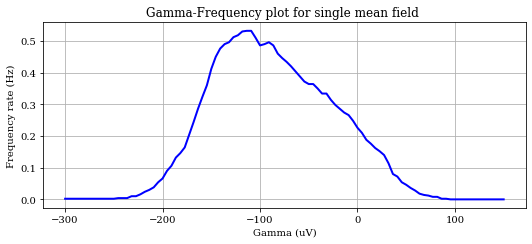

In [183]:
# plot
fig, ax = plt.subplots(figsize=(7.5,3.5))
ax.plot(results.gamma/uV, results.frequency, label="Synchronization rate", lw=2.0, c='b')[0]

ax.set(title=f"Gamma-Frequency plot for single mean field ",
       xlabel="Gamma (uV)",
       ylabel="Frequency rate (Hz)")
ax.grid()

fig.show()
fig.tight_layout()

fig.savefig('./img/gamma-frequency_single.pdf')

In [24]:
# compute 95p confidence intervals (NO)

### 4.Two (ephaptically) coupled populations

In [12]:
def run_two_coupled_populations(model, gamma_ephaptic, external = 0*uV, dt=1*ms, tmax=20*s, seed=100):
    np.random.seed(seed)

    states = np.zeros((2, 3))
    states[:, 0] = 100 * Hz
    states[:, 1] = 100 * Hz
    
    t = 0
    solution = []
    while t < tmax: # sde_step(dt, rexc, rinh) usamos los r_inh del otro modelop para el coupling
        states[0, :] = model.sde_step(dt, *states[0, :], -states[1, 0] * gamma_ephaptic + external)
        states[1, :] = model.sde_step(dt, *states[1, :], -states[0, 0] * gamma_ephaptic + external)
        t += dt
        solution.append(states.copy())
        
    solution = np.array(solution)
    time = np.arange(solution.shape[0]) * dt
    return time, solution

In [13]:
gamma_ephaptic = 65*uV / (6000*Hz) # ephaptic coupling coefficient
tmax = 20*s
seed = 100
thr = 4000 # Just for the analysis
time, solution = run_two_coupled_populations(model, gamma_ephaptic, tmax=tmax, seed=seed)

Simple plot

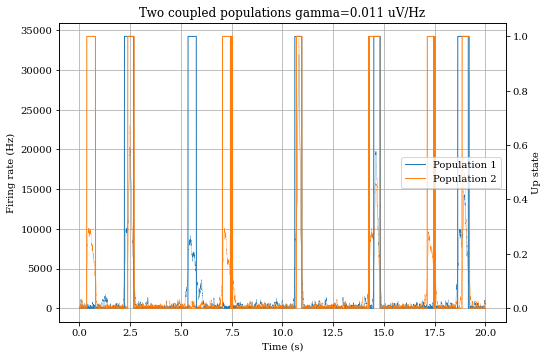

In [189]:
# plot (excitatory) signal
fig, ax = plt.subplots(figsize=(8,5.5))
ax.plot(time, solution[:,0,0], lw=0.25)
ax.plot(time, solution[:,1,0], lw=0.25)

# plot state
ax2 = ax.twinx()
ax2.plot(time, solution[:,0,0]>thr, label="Population 1", lw=1, c="tab:blue")
ax2.plot(time, solution[:,1,0]>thr, label="Population 2", lw=1, c="tab:orange")

# details
ax2.legend()
ax.grid()
ax.set(title=f"Two coupled populations gamma={gamma_ephaptic/uV:.3f} uV/Hz",
       xlabel="Time (s)",
       ylabel="Firing rate (Hz)")
ax2.set(ylabel="Up state")

fig.show()

Complex plot

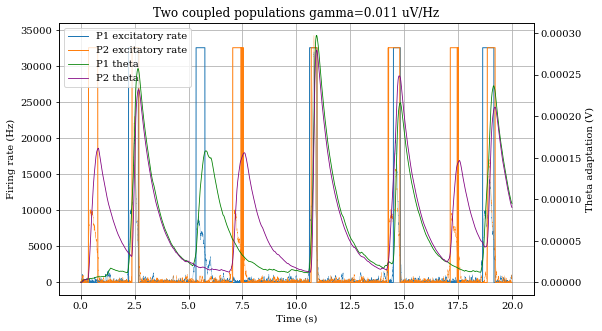

In [190]:
# plot (excitatory) signal
t1 = 20
n = int(t1/dt)

fig, ax = plt.subplots(figsize=(8.5,5))
ax.plot(time[:n], solution[:n,0,0], lw=0.25)
ax.plot(time[:n], solution[:n,1,0], lw=0.25)

# plot state
l1 = ax.plot(time[:n], 0.95*np.max(solution)*(solution[:n,0,0]>thr), label="P1 excitatory rate", lw=1, c="tab:blue")[0]
l2 = ax.plot(time[:n], 0.95*np.max(solution)*(solution[:n,1,0]>thr), label="P2 excitatory rate", lw=1, c="tab:orange")[0]

# plot 
ax2 = ax.twinx()
l3 = ax2.plot(time[:n], solution[:n,0,2], label="P1 theta", lw=0.8, c="green")[0]
l4 = ax2.plot(time[:n], solution[:n,1,2], label="P2 theta", lw=0.8, c="purple")[0]

# details
lines = [l1,l2,l3,l4]
ax.legend(lines, [l.get_label() for l in lines],loc=2)
ax.set(title=f"Two coupled populations gamma={gamma_ephaptic/uV:.3f} uV/Hz",
       xlabel="Time (s)",
       ylabel="Firing rate (Hz)")
ax2.set(ylabel="Theta adaptation (V)")
ax.grid()

fig.show()

Results analysis

In [14]:
from scipy import signal, special

In [15]:
def calc_pli(solution, dt, n_subsamp=100, filter_order=5, cutoff_frequency=1):
    """Calculate the phase locking index (PLI)"""
    # subsample signal
    y = solution[::n_subsamp, :, 0].copy()
    
    # filter signal
    sampling_frequency = 1 / (dt * n_subsamp)
    b, a = signal.iirfilter(filter_order,  cutoff_frequency * 2 / sampling_frequency, btype='lowpass')
    y_filtered = signal.filtfilt(b, a, y[:], axis=0)
    phases = np.angle(signal.hilbert(y_filtered, axis=0))
    
    # calculate pairwise phase locking indice
    # Pensar bien las transformaciones de las listas con las fases
    pli = np.abs(np.mean(np.exp((phases[:, :, None] - phases[:, None, :])*1j), axis=0))
    
    # zero out the diagonal for better visualisation
    ij = np.arange(pli.shape[0])
    #pli[ij, ij] = np.NaN
    return pli

In [16]:
p1_freq = count_peaks(solution[:,0,0])/tmax
p2_freq = count_peaks(solution[:,1,0])/tmax

p1_mean = np.mean(solution[:,0,0]>thr)
p2_mean = np.mean(solution[:,1,0]>thr)

corr_coef = np.corrcoef(solution[:,:,0].T>thr)[0,1]
pli = calc_pli(solution,dt)[0,1]

In [17]:
print(f"Seed={seed}, Coupling={gamma_ephaptic/uV:.3f} uV/Hz, P1 freq={p1_freq:.3f} Hz, P2 freq={p2_freq:.3f} Hz, P1 mean={p1_mean:.3f}, P2 mean={p2_mean:.3f}, Corr coef={corr_coef:.3f}, PLI={pli:.3f}")

Seed=100, Coupling=0.011 uV/Hz, P1 freq=0.250 Hz, P2 freq=0.350 Hz, P1 mean=0.103, P2 mean=0.137, Corr coef=0.426, PLI=0.422


Run experiments

In [45]:
# params
fn = "coupling_results.txt"
tmax = 400*s # (!)
couplings = np.linspace(0, 65. * uV / (6000*Hz), 30)
# seeds = np.linspace(100,100000,10,dtype=int)
seeds = [1000]

write(fn,"coupling,seed,p1freq,p1mean,p2freq,p2mean,corr,pli\n",t="w")

for gamma_ephaptic in couplings:
    current = 0
    print(f"\nCurrent gamma coupling == {gamma_ephaptic/uV:.5f} uV/Hz")
    for seed in seeds:
        _ , solution = run_two_coupled_populations(model, gamma_ephaptic, tmax=tmax, seed=seed)
        
        p1_freq = count_peaks(solution[:,0,0])/tmax
        p2_freq = count_peaks(solution[:,1,0])/tmax

        p1_mean = np.mean(solution[:,0,0]>thr)
        p2_mean = np.mean(solution[:,1,0]>thr)

        corr_coef = np.corrcoef(solution[:,:,0].T>thr)[0,1]
        pli = calc_pli(solution,dt)[0,1]       
        
        write(fn,f"{gamma_ephaptic}, {seed}, {p1_freq}, {p1_mean}, {p2_freq}, {p2_mean}, {corr_coef}, {pli}\n")

        print(".",end="")
        #print(f"Coupling={gamma_ephaptic/uV:.3f} uV/Hz, Seed={seed}, P1 freq={p1_freq:.3f} Hz, P2 freq={p2_freq:.3f} Hz, P1 mean={p1_mean:.3f}, P2 mean={p2_mean:.3f}, Corr coef={corr_coef:.3f}, PLI={pli:.3f}")    
    
    #print(f"Gamma = {gamma/uV:.2f} uV - Frequency (avg) = {current/10:.2f} Hz")


Current gamma coupling == 0.00000 uV/Hz
.
Current gamma coupling == 0.00037 uV/Hz
.
Current gamma coupling == 0.00075 uV/Hz
.
Current gamma coupling == 0.00112 uV/Hz
.
Current gamma coupling == 0.00149 uV/Hz
.
Current gamma coupling == 0.00187 uV/Hz
.
Current gamma coupling == 0.00224 uV/Hz
.
Current gamma coupling == 0.00261 uV/Hz
.
Current gamma coupling == 0.00299 uV/Hz
.
Current gamma coupling == 0.00336 uV/Hz
.
Current gamma coupling == 0.00374 uV/Hz
.
Current gamma coupling == 0.00411 uV/Hz
.
Current gamma coupling == 0.00448 uV/Hz
.
Current gamma coupling == 0.00486 uV/Hz
.
Current gamma coupling == 0.00523 uV/Hz
.
Current gamma coupling == 0.00560 uV/Hz
.
Current gamma coupling == 0.00598 uV/Hz
.
Current gamma coupling == 0.00635 uV/Hz
.
Current gamma coupling == 0.00672 uV/Hz
.
Current gamma coupling == 0.00710 uV/Hz
.
Current gamma coupling == 0.00747 uV/Hz
.
Current gamma coupling == 0.00784 uV/Hz
.
Current gamma coupling == 0.00822 uV/Hz
.
Current gamma coupling == 0.00859

<ipython-input-3-447f67a31b1e>:29: RuntimeWarning: divide by zero encountered in double_scalars
  return 1. / (2 * tau_eff) * (special.erfc((threshold - mu_u) /
<ipython-input-3-447f67a31b1e>:94: RuntimeWarning: overflow encountered in double_scalars
  return rexc * self.n_e, rinh * self.n_i
<ipython-input-3-447f67a31b1e>:74: RuntimeWarning: invalid value encountered in double_scalars
  mu_u = (self.E_l * self.g_l + self.E_e * mu_ge + self.E_i * mu_gi) / gtot


.

In [ ]:
# Repeat previous experiment with constant gamma

Plot results

In [175]:
file_name = "1_coupling_results.txt"
results = pd.read_csv(file_name)

In [176]:
results.head()

,coupling,seed,p1freq,p1mean,p2freq,p2mean,corr,pli
0,0.000000e+00,1000,0.2175,0.087847,0.2250,0.091507,0.000139,0.187281
1,3.735632e-10,1000,0.2150,0.087657,0.2275,0.092775,0.010148,0.197863
2,7.471264e-10,1000,0.2150,0.088087,0.2275,0.092897,0.019501,0.203288
3,1.120690e-09,1000,0.2150,0.088485,0.2275,0.092752,0.037845,0.217713
4,1.494253e-09,1000,0.2225,0.091770,0.2300,0.094100,0.044067,0.227584


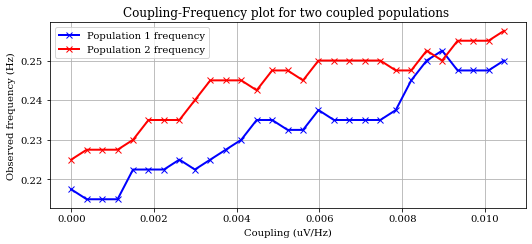

In [177]:
# plot
fig, ax = plt.subplots(figsize=(7.5,3.5))

ax.plot(results['coupling']/uV, results['p1freq'], 'x-', label="Population 1 frequency", lw=2.0, c='b')[0]
ax.plot(results['coupling']/uV, results['p2freq'], 'x-', label="Population 2 frequency", lw=2.0, c='r')[0]

ax.legend()
ax.set(title=f"Coupling-Frequency plot for two coupled populations ",
       xlabel="Coupling (uV/Hz)",
       ylabel="Observed frequency (Hz)")
ax.grid()

fig.tight_layout()

fig.show()
fig.savefig('./img/coupling-frequency_pair.pdf')

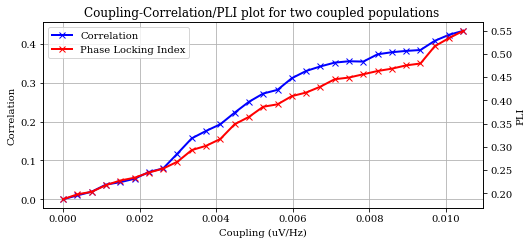

In [179]:
# plot
fig, ax = plt.subplots(figsize=(7.5,3.5))

l1 = ax.plot(results['coupling']/uV, results['corr'], 'x-', label="Correlation", lw=2.0, c='b')[0]
ax2 = ax.twinx()
l2 = ax2.plot(results['coupling']/uV, results['pli'], 'x-', label="Phase Locking Index", lw=2.0, c='r')[0]

lines = [l1,l2]

ax.legend(lines, [l.get_label() for l in lines],loc=2)
ax.set(title=f"Coupling-Correlation/PLI plot for two coupled populations ",
       xlabel="Coupling (uV/Hz)",
       ylabel="Correlation")
ax2.set(ylabel="PLI")
ax.grid()

fig.tight_layout()

fig.show()
fig.savefig('./img/coupling-PLI&corr_pair.pdf')

### 5.Two coupled populations with exogenous current

In [18]:
# params
fn = "gamma-coupling_results.txt"
time = 400*s # (!)

couplings = np.linspace(0, 60. * uV / (6000*Hz), 8)
gammas = np.linspace(-300,150,15)*uV

#seeds = np.linspace(100,100000,10,dtype=int)
seeds = [100]

write(fn,"external,coupling,seed,p1freq,p1mean,p2freq,p2mean,corr,pli\n",t="w")

for external_gamma in gammas:
    for gamma_ephaptic in couplings:
        current = 0
        print(f"\nCurrent gamma external-coupling == {external_gamma/uV:.4f}-{gamma_ephaptic/uV:.4f}")
        for seed in seeds:
            _ , solution = run_two_coupled_populations(model, gamma_ephaptic, external=external_gamma, tmax=time, seed=seed)

            p1_freq = count_peaks(solution[:,0,0])/tmax
            p2_freq = count_peaks(solution[:,1,0])/tmax

            p1_mean = np.mean(solution[:,0,0]>thr)
            p2_mean = np.mean(solution[:,1,0]>thr)

            corr_coef = np.corrcoef(solution[:,:,0].T>thr)[0,1]
            pli = calc_pli(solution,dt)[0,1]       

            #current += frequency
            write(fn,f"{external_gamma}, {gamma_ephaptic}, {seed}, {p1_freq}, {p1_mean}, {p2_freq}, {p2_mean}, {corr_coef}, {pli}\n")

            print(".",end="")
            #print(f"External={external_gamma/uV} uV, Coupling={gamma_ephaptic/uV:.3f} uV/Hz, Seed={seed}, P1 freq={p1_freq:.3f} Hz, P2 freq={p2_freq:.3f} Hz, P1 mean={p1_mean:.3f}, P2 mean={p2_mean:.3f}, Corr coef={corr_coef:.3f}, PLI={pli:.3f}")    

        #print(f"Gamma = {gamma/uV:.2f} uV - Frequency (avg) = {current/10:.2f} Hz")


Current gamma external-coupling == -300.0000-0.0000
.
Current gamma external-coupling == -300.0000-0.0014
.
Current gamma external-coupling == -300.0000-0.0029
.
Current gamma external-coupling == -300.0000-0.0043


<ipython-input-3-447f67a31b1e>:29: RuntimeWarning: divide by zero encountered in double_scalars
  return 1. / (2 * tau_eff) * (special.erfc((threshold - mu_u) /
<ipython-input-3-447f67a31b1e>:94: RuntimeWarning: overflow encountered in double_scalars
  return rexc * self.n_e, rinh * self.n_i
<ipython-input-3-447f67a31b1e>:74: RuntimeWarning: invalid value encountered in double_scalars
  mu_u = (self.E_l * self.g_l + self.E_e * mu_ge + self.E_i * mu_gi) / gtot


.
Current gamma external-coupling == -300.0000-0.0057
.
Current gamma external-coupling == -300.0000-0.0071
.
Current gamma external-coupling == -300.0000-0.0086
.
Current gamma external-coupling == -300.0000-0.0100
.
Current gamma external-coupling == -267.8571-0.0000
.
Current gamma external-coupling == -267.8571-0.0014
.
Current gamma external-coupling == -267.8571-0.0029
.
Current gamma external-coupling == -267.8571-0.0043
.
Current gamma external-coupling == -267.8571-0.0057
.
Current gamma external-coupling == -267.8571-0.0071
.
Current gamma external-coupling == -267.8571-0.0086
.
Current gamma external-coupling == -267.8571-0.0100
.
Current gamma external-coupling == -235.7143-0.0000
.
Current gamma external-coupling == -235.7143-0.0014
.
Current gamma external-coupling == -235.7143-0.0029
.
Current gamma external-coupling == -235.7143-0.0043
.
Current gamma external-coupling == -235.7143-0.0057
.
Current gamma external-coupling == -235.7143-0.0071
.
Current gamma external-cou

/home/jc/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


.
Current gamma external-coupling == 117.8571-0.0014
.
Current gamma external-coupling == 117.8571-0.0029
.
Current gamma external-coupling == 117.8571-0.0043
.
Current gamma external-coupling == 117.8571-0.0057
.
Current gamma external-coupling == 117.8571-0.0071
.
Current gamma external-coupling == 117.8571-0.0086
.
Current gamma external-coupling == 117.8571-0.0100
.
Current gamma external-coupling == 150.0000-0.0000
.
Current gamma external-coupling == 150.0000-0.0014
.
Current gamma external-coupling == 150.0000-0.0029
.
Current gamma external-coupling == 150.0000-0.0043
.
Current gamma external-coupling == 150.0000-0.0057
.
Current gamma external-coupling == 150.0000-0.0071
.
Current gamma external-coupling == 150.0000-0.0086
.
Current gamma external-coupling == 150.0000-0.0100
.

Data analysis

In [51]:
data = pd.read_csv("1_gamma-coupling_results.txt")
data['corr'] = pd.to_numeric(data['corr'], errors='coerce')
data['pli'] = pd.to_numeric(data['pli'], errors='coerce')
data = data.fillna(0)

In [52]:
data.dtypes

external    float64
coupling    float64
seed          int64
p1freq      float64
p1mean      float64
p2freq      float64
p2mean      float64
corr        float64
pli         float64
dtype: object

In [53]:
data.head(16)

,external,coupling,seed,p1freq,p1mean,p2freq,p2mean,corr,pli
0,-0.000300,0.000000e+00,100,0.05,0.999840,0.05,0.999808,0.911670,0.998954
1,-0.000300,1.428571e-09,100,0.05,0.999840,0.05,0.999810,0.917649,0.999108
2,-0.000300,2.857143e-09,100,0.05,0.999840,0.05,0.999810,0.917649,0.999230
3,-0.000300,4.285714e-09,100,0.05,0.002345,0.05,0.002312,0.993030,0.000000
4,-0.000300,5.714286e-09,100,0.05,0.002307,0.05,0.002275,0.992917,0.000000
5,-0.000300,7.142857e-09,100,0.05,0.002290,0.05,0.002262,0.993964,0.000000
6,-0.000300,8.571429e-09,100,0.05,0.002280,0.05,0.002252,0.993937,0.000000
7,-0.000300,1.000000e-08,100,0.05,0.002272,0.05,0.002247,0.994472,0.000000
8,-0.000268,0.000000e+00,100,0.05,0.999608,0.05,0.999473,0.362333,0.998594
9,-0.000268,1.428571e-09,100,0.05,0.999738,0.05,0.999740,0.631490,0.998831


In [109]:
coups

array([-2.00e-04, -1.75e-04, -1.25e-04, -7.50e-05, -2.50e-05,  0.00e+00,
        5.00e-05,  1.00e-04,  1.50e-04])

In [39]:
j=14
data[column][j*8:(j+1)*8]

112    0.0
113    0.0
114    0.0
115    0.0
116    0.0
117    0.0
118    0.0
119    0.0
Name: p1freq, dtype: float64

In [36]:
couplings/uV

0    0.000000
1    0.001429
2    0.002857
3    0.004286
4    0.005714
5    0.007143
6    0.008571
7    0.010000
Name: coupling, dtype: float64

In [43]:
external.values[4]

-0.0001714285714285

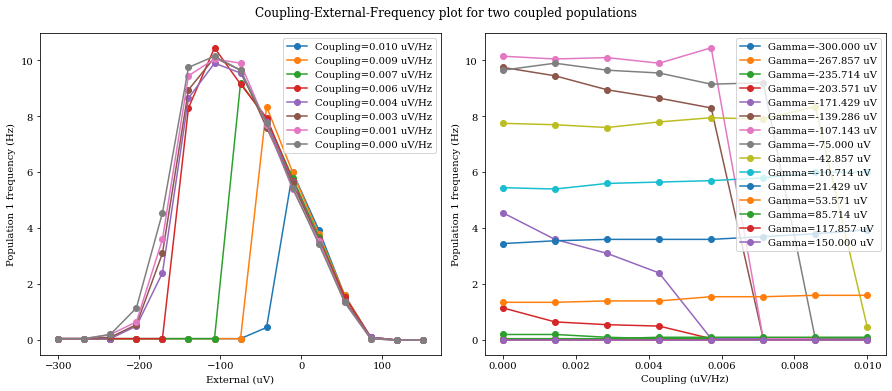

In [62]:
fig, ax = plt.subplots(1,2,figsize=(12.5,5.5))

external = data['external'].values[0::8]
couplings = data['coupling'].values[:8]

column = 'p1freq'

# first axis
for i in range(7,-1,-1):
    plis = data[column][i::8]
    ax[0].plot(external/uV, plis, 'o-', label=f'Coupling={couplings[i]/uV:.3f} uV/Hz')
ax[0].set(xlabel="External (uV)",
       ylabel="Population 1 frequency (Hz)")
ax[0].legend(loc=1)

# second axis
for j in range(0,15):
    plis = data[column][j*8:(j+1)*8]
    ax[1].plot(couplings/uV, plis, 'o-', label=f'Gamma={external[j]/uV:.3f} uV')

ax[1].set(xlabel="Coupling (uV/Hz)",
       ylabel="Population 1 frequency (Hz)")
ax[1].legend(loc=1)

fig.suptitle(f"Coupling-External-Frequency plot for two coupled populations")

fig.tight_layout()

fig.show()
fig.savefig('./img/coupling-external-freq_pair.pdf')

In [46]:
data.dtypes

external    float64
coupling    float64
seed          int64
p1freq      float64
p1mean      float64
p2freq      float64
p2mean      float64
corr         object
pli          object
dtype: object

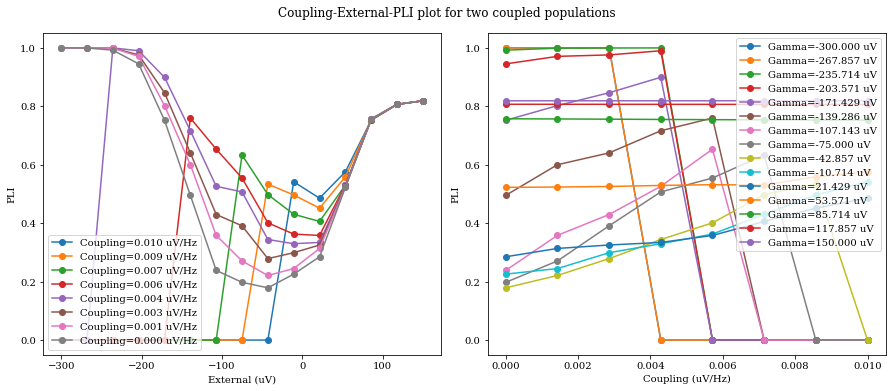

In [63]:
fig, ax = plt.subplots(1,2,figsize=(12.5,5.5))

external = data['external'].values[0::8]
couplings = data['coupling'].values[:8]

column = 'pli'

# first axis
for i in range(7,-1,-1):
    plis = data[column][i::8]
    ax[0].plot(external/uV, plis, 'o-', label=f'Coupling={couplings[i]/uV:.3f} uV/Hz')
ax[0].set(xlabel="External (uV)",
       ylabel="PLI")
ax[0].legend(loc=3)

# second axis
for j in range(0,15):
    plis = data[column][j*8:(j+1)*8]
    ax[1].plot(couplings/uV, plis, 'o-', label=f'Gamma={external[j]/uV:.3f} uV')

ax[1].set(xlabel="Coupling (uV/Hz)",
       ylabel="PLI")
ax[1].legend(loc=1)

fig.suptitle(f"Coupling-External-PLI plot for two coupled populations")

fig.tight_layout()

fig.show()
fig.savefig('./img/coupling-external-pli_pair.pdf')